In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set plotting preferences
sns.set_style("white")

In [3]:
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

test = pd.read_pickle(pickle_path / "test.pkl")
train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")
houses_wEV = utils.get_pickle(pickle_path / "houses_wEV.pkl")
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")

# Determine outliers
outliers = utils.classify_outliers(train)


Number of Outliers: 37
Percent Removed: 2.33%



In [4]:
# Verify that we don't have any negative readings
# This indicates a fundamental error in the data measurement
test = np.where(train.stack() < 0, True, False)
for value in test: 
    if value == True: 
        print("Error. Training data contains negative values.")
        break
else:
    print("No negative power readings in the dataset.")

No negative power readings in the dataset.


In [5]:
# Ratio of houses with and without EVs
ct_w = len(houses_wEV)
ct_wo = len(houses_woEV)
print("{:.2f}% of the training data houses own EVs".format(100*ct_w/(ct_w + ct_wo)))

# Separate into houses with and without EVs
train_w = train.drop(houses_woEV)
train_wo = train.drop(houses_wEV)
labels_w = labels.drop(houses_woEV)
# labels_wo is zero matrix

30.50% of the training data houses own EVs


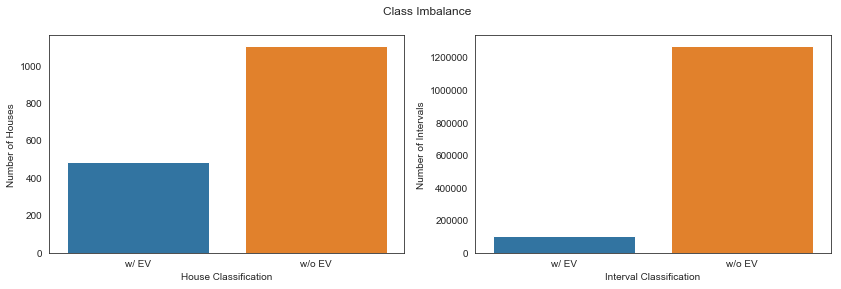

In [88]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# House Imbalance 
sns.barplot(x=["w/ EV", "w/o EV"], 
            y=[len(houses_wEV), len(houses_woEV)],
            ax=axes[0]
            )
axes[0].set_xlabel('House Classification')
axes[0].set_ylabel('Number of Houses');

# Interval Imbalance
sns.barplot(x=["w/ EV", "w/o EV"], 
            y=[vc[1], vc[0]],
            ax=axes[1]
            )
axes[1].set_xlabel('Interval Classification')
axes[1].set_ylabel('Number of Intervals');

f.suptitle('Class Imbalance');
f.savefig(fig_path / "profile_0.png", dpi=400)

In [84]:
# Overall Imbalance
labels_stack = labels.drop(outliers.index).stack()
vc = labels_stack.value_counts()
pct_chrg =  100 * vc[1]/(vc[0] + vc[1])

print("EVs charged during {:.2f}% of all intervals\n"
      "  {} Charging intervals\n"
      "  {} Non-Charing intervals\n\n".format(pct_chrg, vc[1], vc[0]))

# Imbalance for EV-only
labels_stack = labels_w.drop(outliers.index, errors='ignore').stack()
vc = labels_stack.value_counts()
pct_chrg =  100 * vc[1]/(vc[0] + vc[1])

print("EVs charged during {:.2f}% of all intervals at hosues with EVs\n"
      "  {} Charging intervals\n"
      "  {} Non-Charing intervals".format(pct_chrg, vc[1], vc[0]))

vc

EVs charged during 2.36% of all intervals
  105550 Charging intervals
  4367090 Non-Charing intervals


EVs charged during 7.67% of all intervals at hosues with EVs
  105550 Charging intervals
  1271090 Non-Charing intervals


0    1271090
1     105550
dtype: int64

In [101]:
# Determine stats for both classifications
stats = pd.DataFrame(index=train.index)
stats['tot_pwr'] = train.sum(axis=1)
stats['avg_pwr'] = train.mean(axis=1)
stats['median_pwr'] = train.median(axis=1)
stats['min_pwr'] = train.min(axis=1)
stats['max_pwr'] = train.max(axis=1)
stats['tot_chrgs'] = labels.sum(axis=1)
stats['bool_EV'] = np.where(stats['tot_chrgs'] > 0, True, False)

print(stats.describe(percentiles=[]).round(1))
# Drop outliers
stats.drop(outliers.index, errors='ignore', inplace=True)
print(stats.describe(percentiles=[]).round(1))

# Split stats by class
stats_wEV = stats.drop(houses_woEV, errors='ignore').drop(outliers.index, errors='ignore')
stats_woEV = stats.drop(houses_wEV, errors='ignore').drop(outliers.index, errors='ignore')

        tot_pwr  avg_pwr  median_pwr  min_pwr  max_pwr  tot_chrgs
count    1590.0   1590.0      1590.0   1590.0   1590.0     1590.0
mean     4031.3      1.4         1.1      0.3      5.7       67.2
std      8921.2      3.1         2.8      1.6      7.1      115.7
min       814.8      0.3         0.0      0.0      0.6        0.0
50%      2446.7      0.8         0.6      0.1      4.5        0.0
max    244527.1     84.9        75.8     50.9    163.1      685.0
       tot_pwr  avg_pwr  median_pwr  min_pwr  max_pwr  tot_chrgs
count   1553.0   1553.0      1553.0   1553.0   1553.0     1553.0
mean    3127.8      1.1         0.8      0.2      4.9       68.0
std     2526.9      0.9         0.8      0.4      2.6      116.3
min      814.8      0.3         0.0      0.0      0.6        0.0
50%     2417.1      0.8         0.6      0.1      4.4        0.0
max    30073.7     10.4        11.3      5.2     19.6      685.0


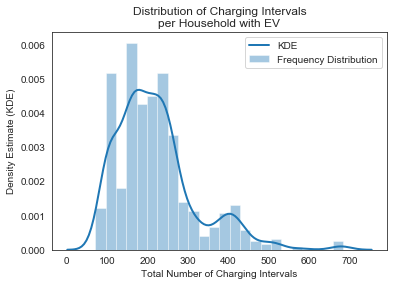

In [57]:
# Distribution of the number of charges
plot = sns.distplot(stats_wEV['tot_chrgs'],
                   kde_kws={"lw": 2, "label": "KDE"},
                   hist_kws={"label":"Frequency Distribution"});
plt.title('Distribution of Charging Intervals\nper Household with EV');
plt.xlabel('Total Number of Charging Intervals');
plt.ylabel('Density Estimate (KDE)');
plot.get_figure().savefig(fig_path / "profile_1.png", dpi=400)



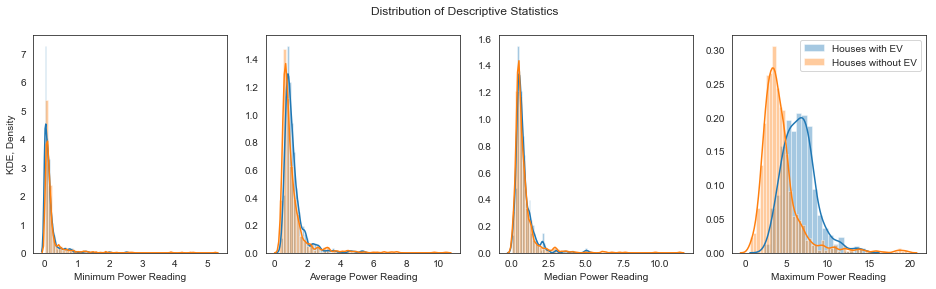

In [71]:
# Plot distribution of summary stats
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
# sns.despine(top=True, right=True)

# Min Power Reading
sns.distplot(stats_wEV['min_pwr'], ax=axes[0], label="Houses with EV")
sns.distplot(stats_woEV['min_pwr'], ax=axes[0], label="Houses without EV")
axes[0].set_xlabel('Minimum Power Reading')
axes[0].set_ylabel('KDE, Density');

# Mean Power Reading
sns.distplot(stats_wEV['avg_pwr'], ax=axes[1], label="Houses with EV")
sns.distplot(stats_woEV['avg_pwr'], ax=axes[1], label="Houses without EV")
axes[1].set_xlabel('Average Power Reading');

# Median Power Reading
sns.distplot(stats_wEV['median_pwr'], ax=axes[2], label="Houses with EV")
sns.distplot(stats_woEV['median_pwr'], ax=axes[2], label="Houses without EV")
axes[2].set_xlabel('Median Power Reading');

# Max Power Reading
sns.distplot(stats_wEV['max_pwr'], ax=axes[3], label="Houses with EV")
sns.distplot(stats_woEV['max_pwr'], ax=axes[3], label="Houses without EV")
axes[3].set_xlabel('Maximum Power Reading')
axes[3].legend();


# plt.setp(axes)
f.suptitle('Distribution of Descriptive Statistics');
f.savefig(fig_path / "profile_2.png", dpi=400)

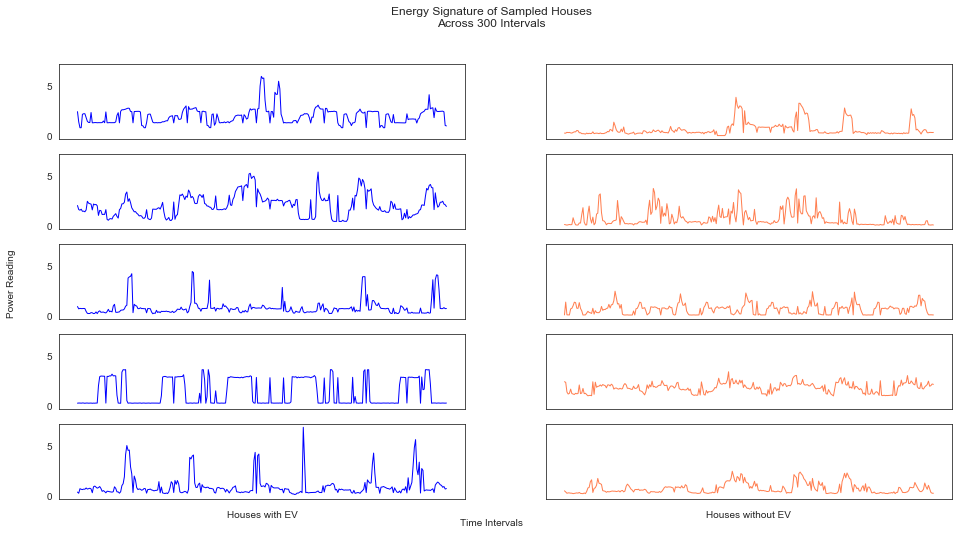

In [55]:
# Randomly sample houses with E-Cars
# Note: This random state was selected to exaggerate the effect
sample_w = train_w.iloc[:, :300].sample(5, random_state=2)
sample_wo = train_wo.iloc[:, :300].sample(5, random_state=2)

f, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(16, 8))

for i in range(5):
    sns.lineplot(data=sample_w.iloc[i, :].T, ax=axes[i,0], color="blue", lw=1)
    sns.lineplot(data=sample_wo.iloc[i, :].T, ax=axes[i,1], color="coral", lw=1)

axes[4,0].set_xlabel("Houses with EV")
axes[4,1].set_xlabel("Houses without EV")
axes[4,0].set_xticklabels([])

f.text(0.5, 0.08, 'Time Intervals', ha='center')
f.text(0.08, 0.5, 'Power Reading', va='center', rotation='vertical')

# plt.tight_layout(pad=6)
f.suptitle('Energy Signature of Sampled Houses\nAcross 300 Intervals');
f.savefig(fig_path / "profile_3.png", dpi=400)